In [1]:
import numpy as np
import scipy 


In [2]:
## this code is for simulating gene-peak level causal models
## Peaks ~ Multinomial(P, N)
## P = f_p(T_p(t), E_p), t ~ uniform(0,100), T_p(t) is a function with input t, E_p is the Gaussian Noise term
## Gene ~ Negative_Bionomial(r, PR, size)
## r = f_r(T_r(t), E_g), PR = f_pr(T_pr(t), E_g2)

In [125]:
## Step 1: Simulate the Time 
low = 0  # lower bound
high = 1  # upper bound
size = 10000  # generate 100 samples
T = np.random.uniform(low, high, size)
print(T)

[0.21739445 0.8641608  0.26695436 ... 0.40124537 0.02242843 0.30093663]


In [127]:
## Step 2: define P(T) abnd E; generate the linear combination of them as P; then generate multinomial Peaks
P_T = T / 2 + 0.2
E = np.random.normal(0, 0.001, size)
P = P_T + E 
print(P)
trials = 10
Peaks = np.random.binomial(trials, P, size)
Peaks

[0.31051287 0.63322278 0.33200784 ... 0.39966074 0.21041289 0.35082466]


array([1, 6, 5, ..., 4, 0, 2])

In [128]:
# Step 3:  defile Negative Binomial Distribution and generate Gene expression values
## We have the coupled case
print(Peaks.shape)
r = T + np.abs(np.random.normal(0, 0.1)) + np.abs(np.cos(Peaks)) 
# print(r)
# print(P)
PR =  P+ np.abs(np.cos(Peaks))
for i  in range(len(PR)):
    p = PR[i]
    if  p >1:
        PR[i] = p-1
print(PR.shape)
genes = np.random.negative_binomial(r, PR, size)


(10000,)
(10000,)


In [129]:
genes = np.expand_dims(genes,1)
Peaks = np.expand_dims(Peaks, 1)
T = np.expand_dims(T, 1)
T.shape

(10000, 1)

In [130]:
## 
from causal_utils import infer_nonsta_dir

score_ar, _, _ = infer_nonsta_dir(Peaks, genes, T, width=0.1)
score_ra, _, _ =infer_nonsta_dir(genes, Peaks, T, width=0.1)
# score_ar = np.log(score_ar)
# score_ra = np.log(score_ra)
# score = -(score_ar - score_ra)
decouple_score = -(score_ar - score_ra)
couple_score =  score_ar - score_ra 

print(decouple_score, couple_score)

KeyboardInterrupt: 

In [113]:
T.shape

(100, 1)

In [114]:
## simulate Decouple 
TT = np.squeeze(T, axis=1)
Peaks2 = np.squeeze(Peaks, axis=1)
r = 3*TT + 2 * np.abs(np.random.normal(0, 0.1)) + np.abs(np.cos(Peaks2))
PR =  np.sin(TT)+ np.abs(np.random.normal(0, 0.005))  + np.cos(Peaks2)

for i  in range(len(PR)):
    p = PR[i]
    if p<= 0 or p >1:
        PR[i] = 0.1
# print(PR)
genes = np.random.negative_binomial(r, PR, size) 

In [115]:
genes = np.expand_dims(genes,1)


In [116]:
score_ar, _, _ = infer_nonsta_dir(Peaks, genes, T, width=0.1)
score_ra, _, _ =infer_nonsta_dir(genes, Peaks, T, width=0.1)
decouple_score = -(score_ar - score_ra)
couple_score =  score_ar - score_ra 

print(decouple_score, couple_score)

-0.0008312164355141899 0.0008312164355141899


In [38]:
## Ok, let's integrate these functions, 
from causal_utils import infer_nonsta_dir

def causal_delta_score(genes, Peaks, T):
    score_ar, _, _ = infer_nonsta_dir(Peaks, genes, T, width=0.1)
    score_ra, _, _ =infer_nonsta_dir(genes, Peaks, T, width=0.1)
    decouple_score = -(score_ar - score_ra)
    couple_score =  score_ar - score_ra 
    return decouple_score, couple_score , score_ar, score_ra




def generate_couple_decouple_pairs(samples=10, size=100):
    P_P = []

    couple_P_G = []
    couple_R_G = []

    decouple_P_G = []
    decouple_R_G = []

    decouple_d =[]
    decouple_c = []

    couple_d = []
    couple_c = []
    PT = []
    DT = []
    CT = []
    TT = []

    dars = []
    dras = []

    cars = []
    cras = []

    low = 0  # lower bound
    high = 1  # upper bound
    trials = 10
    for s in range(samples): 
        print("iteration {} ...".format(s))
        ## Peaks
        T = np.random.uniform(low, high, size)
        TT = np.concatenate([TT, T])
        P = T
        Peaks = np.random.binomial(trials, P, size)
        P_P.append(P)
        PT = np.concatenate([PT, Peaks])

        ## couple gene
        r =  T/10
        # r =  trials

        PR =  P + Peaks/100
        for i  in range(len(PR)):
            p = PR[i]
            if  p >1:
                PR[i] = p-1
        couple_genes = np.random.negative_binomial(r, PR, size)
        couple_R_G.append(r)
        couple_P_G.append(PR)
        CT = np.concatenate([CT, couple_genes])




        # r_d =   np.abs(np.cos(1000*T)) + np.abs(np.cos(1000*Peaks))
        # r_d = np.exp(np.cos(100*T))
        r_d = np.exp(10*T)

        PR_d =  np.abs(np.cos(1000*T+100*Peaks))
        # PR_d =  1- np.random.uniform(low=0, high=T+Peaks/100)
        # PR_d =  1.0 / np.exp((100*T+Peaks))


        decouple_P_G.append(PR_d)
        decouple_R_G.append(r_d)


        for i  in range(len(PR_d)):
            p = PR_d[i]
            if p<= 0:
                PR_d[i] = np.abs(p)
            elif p> 1:
                PR_d[i] = p-1


        decouple_genes = np.random.negative_binomial(r_d, PR_d, size) / 1e3
        DT = np.concatenate([DT, decouple_genes])

        couple_genes = np.expand_dims(couple_genes,1)
        decouple_genes = np.expand_dims(decouple_genes,1)
        Peaks = np.expand_dims(Peaks, 1)
        Peaks2 = Peaks.copy() 
        T = np.expand_dims(T,1)

        # print(decouple_genes.shape, Peaks.shape, T.shape)
        dds, dcs , dar, dra = causal_delta_score(decouple_genes, Peaks, T)
        decouple_d.append(dds)
        decouple_c.append(dcs)
        dars.append(dar)
        dras.append(dra)


        # print(couple_genes.shape, Peaks.shape, T.shape)

        cds, ccs, car, cra = causal_delta_score(couple_genes, Peaks2, T)
        couple_d.append(cds)
        couple_c.append(ccs)
        cars.append(car)
        cras.append(cra)
        

    return  couple_d, decouple_d, cars, dars, dras, cras, couple_P_G, couple_R_G, decouple_P_G, decouple_R_G, P_P , CT,  DT, TT, PT




In [39]:
couple_d, decouple_d, cars, dars, dras, cras, couple_P_G, couple_R_G, decouple_P_G, decouple_R_G, P_P , couple_genes,decouple_genes, T, Peaks = generate_couple_decouple_pairs(samples=100, size=300)

iteration 0 ...
iteration 1 ...
iteration 2 ...
iteration 3 ...
iteration 4 ...
iteration 5 ...
iteration 6 ...
iteration 7 ...
iteration 8 ...
iteration 9 ...
iteration 10 ...
iteration 11 ...
iteration 12 ...
iteration 13 ...
iteration 14 ...
iteration 15 ...
iteration 16 ...
iteration 17 ...
iteration 18 ...
iteration 19 ...
iteration 20 ...
iteration 21 ...
iteration 22 ...
iteration 23 ...
iteration 24 ...
iteration 25 ...
iteration 26 ...
iteration 27 ...
iteration 28 ...
iteration 29 ...
iteration 30 ...
iteration 31 ...
iteration 32 ...
iteration 33 ...
iteration 34 ...
iteration 35 ...
iteration 36 ...
iteration 37 ...
iteration 38 ...
iteration 39 ...
iteration 40 ...
iteration 41 ...
iteration 42 ...
iteration 43 ...
iteration 44 ...
iteration 45 ...
iteration 46 ...
iteration 47 ...
iteration 48 ...
iteration 49 ...
iteration 50 ...
iteration 51 ...
iteration 52 ...
iteration 53 ...
iteration 54 ...
iteration 55 ...
iteration 56 ...
iteration 57 ...
iteration 58 ...
iterati

In [600]:
couple_d

[-0.014001459527188467, -0.020485649557951895, -0.021644059628826838]

In [601]:
decouple_d

[0.004831374486669357, 0.0034563091873364565, 0.0035924650480619463]

In [562]:
T.shape

(1000,)

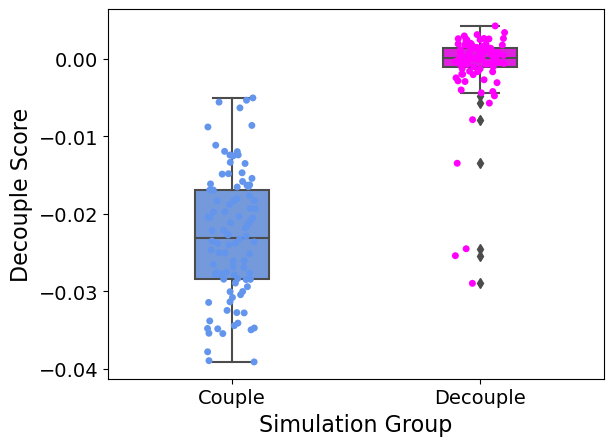

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({'Couple' : couple_d, 'Decouple': decouple_d})
# Convert DataFrame to long format
df_long = pd.melt(df, var_name='Group', value_name='Value')
fig, ax = plt.subplots()
sns.color_palette("Paired")
custom_palette = ["cornflowerblue", "magenta"]
# Create the violin plot
sns.boxplot(x='Group', y='Value', data=df_long, palette=custom_palette, width=0.3)
sns.stripplot(x="Group", y="Value", data=df_long, palette=custom_palette, size=5, jitter=True)

plt.xticks(fontsize=14)  # Set x-tick label size
plt.yticks(fontsize=14)  # Set y-tick label size
plt.xlabel('Simulation Group', fontsize=16)  # Set x-axis label with increased font size
plt.ylabel('Decouple Score', fontsize=16)
# fig.savefig('Benchmark/Simulation_gene_ds_2.pdf', format='pdf', dpi=300)

plt.show()

Text(0, 0.5, 'Decouple Score')

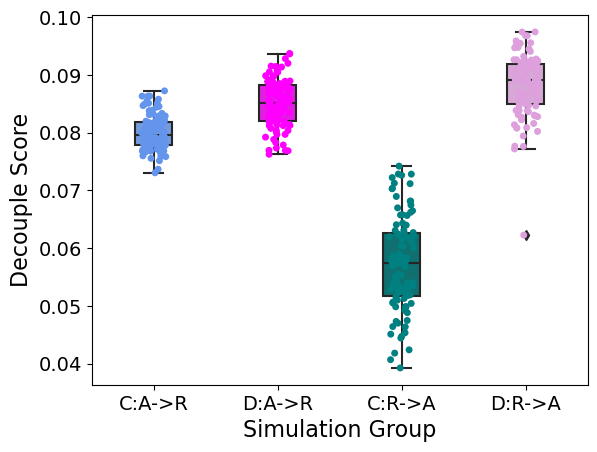

In [40]:
df = pd.DataFrame({'C:A->R': cars, 'D:A->R': dars, "C:R->A": cras, "D:R->A": dras})
# Convert DataFrame to long format
df_long = pd.melt(df, var_name='Group', value_name='Value')
fig, ax = plt.subplots()
sns.color_palette("Paired")
custom_palette = ["cornflowerblue", "magenta", "teal", "plum"]
# Create the violin plot
sns.boxplot(x='Group', y='Value', data=df_long, palette=custom_palette, width=0.3)
sns.stripplot(x="Group", y="Value", data=df_long, palette=custom_palette, size=5, jitter=True)

plt.xticks(fontsize=14)  # Set x-tick label size
plt.yticks(fontsize=14)  # Set y-tick label size
plt.xlabel('Simulation Group', fontsize=16)  # Set x-axis label with increased font size
plt.ylabel('Decouple Score', fontsize=16)
# fig.savefig('Benchmark/Simulation_gene_cdars.pdf', format='pdf', dpi=300)

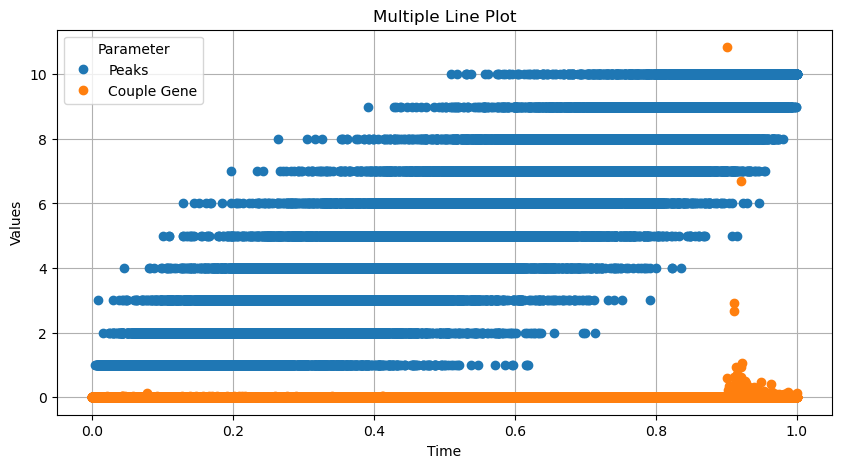

In [19]:
# df = pd.DataFrame({'Peaks': Peaks, 'Couple Gene': couple_genes, "Decouple gene": decouple_genes , "Peaks": Peaks, "Time": T})
df = pd.DataFrame({'Peaks': Peaks, 'Couple Gene': couple_genes/300, "Peaks": Peaks, "Time": T})

# Convert DataFrame to long format
df.set_index('Time', inplace=True)

# Create the violin plot
df.plot(style='o',figsize=(10, 5))  # Adjust the figure size as needed
plt.title('Multiple Line Plot')
plt.xlabel('Time')
plt.ylabel('Values')
plt.grid(True)
plt.legend(title='Parameter')
plt.show()

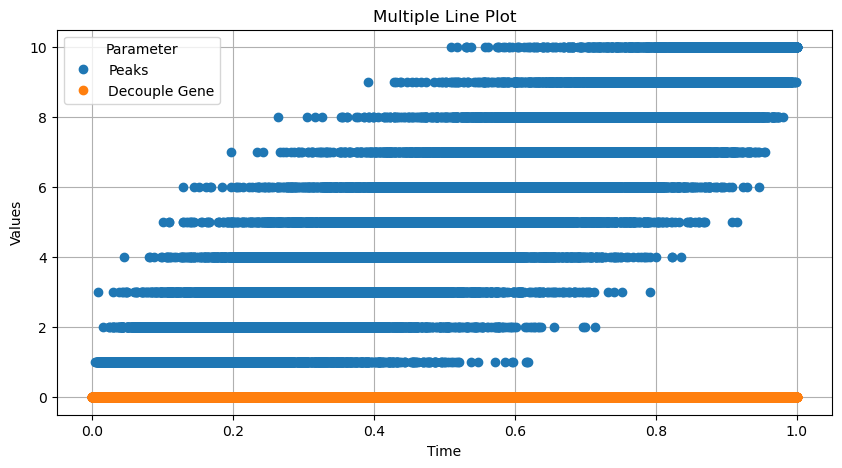

In [18]:
df = pd.DataFrame({'Peaks': Peaks, 'Decouple Gene': decouple_genes/1e15, "Peaks": Peaks, "Time": T})

# Convert DataFrame to long format
df.set_index('Time', inplace=True)

# Create the violin plot
df.plot(style='o',figsize=(10, 5))  # Adjust the figure size as needed
plt.title('Multiple Line Plot')
plt.xlabel('Time')
plt.ylabel('Values')
plt.grid(True)
plt.legend(title='Parameter')
plt.show()

In [635]:
couple_P_G

array([0.65402519, 0.01421399, 0.86379092, ..., 0.45206572, 0.15598919,
       0.08194485])

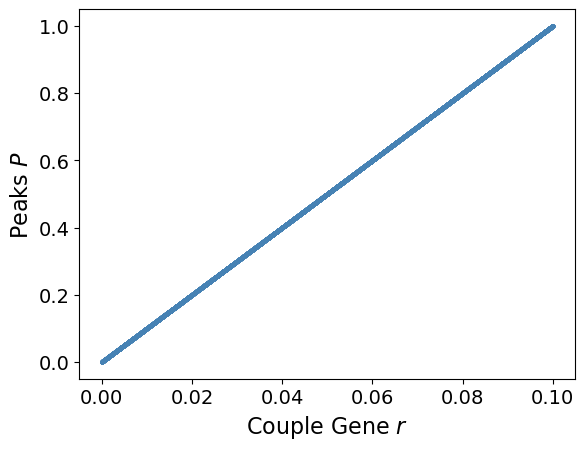

In [694]:
import matplotlib.pyplot as plt

# couple_P_G, couple_R_G, decouple_P_G, decouple_R_G, P_P ,

# couple_P_G = np.concatenate(couple_P_G)
# couple_R_G = np.concatenate(couple_R_G)

# P_P = np.concatenate(P_P)

# decouple_P_G = np.concatenate(decouple_P_G)
# decouple_R_G = np.concatenate(decouple_R_G)


fig, ax = plt.subplots()

plt.scatter(couple_R_G, P_P, color="steelblue", s=3)
plt.xticks(fontsize=14)  # Set x-tick label size
plt.yticks(fontsize=14)  # Set y-tick label size
plt.xlabel('Couple Gene $r$', fontsize=16)  # Set x-axis label with increased font size
plt.ylabel('Peaks $P$', fontsize=16)
fig.savefig('Benchmark/Simulation_gene_r_P_c_3.pdf', format='pdf', dpi=300)

Text(0, 0.5, 'Peaks $P$')

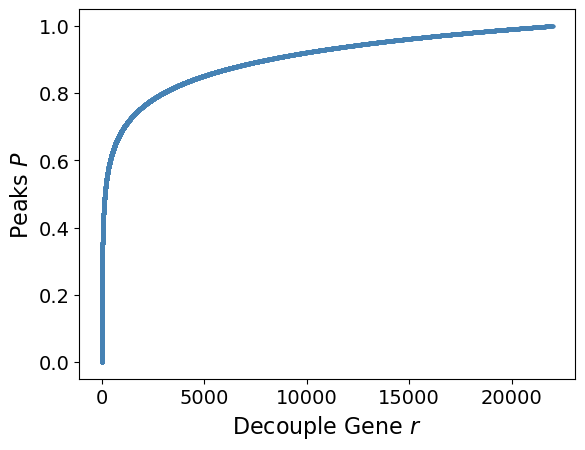

In [20]:
fig, ax = plt.subplots()

plt.scatter(decouple_R_G, P_P, color="steelblue", s=3)
plt.xticks(fontsize=14)  # Set x-tick label size
plt.yticks(fontsize=14)  # Set y-tick label size
plt.xlabel('Decouple Gene $r$', fontsize=16)  # Set x-axis label with increased font size
plt.ylabel('Peaks $P$', fontsize=16)
fig.savefig('Benchmark/Simulation_gene_r_P_d_3.pdf', format='pdf', dpi=300)

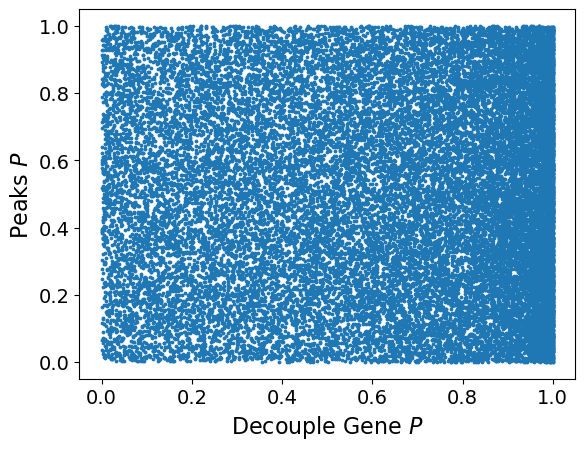

In [23]:
fig, ax = plt.subplots()


plt.scatter(decouple_P_G, P_P, s=3)
plt.xticks(fontsize=14)  # Set x-tick label size
plt.yticks(fontsize=14)  # Set y-tick label size
plt.xlabel('Decouple Gene $P$', fontsize=16)  # Set x-axis label with increased font size
plt.ylabel('Peaks $P$', fontsize=16)
fig.savefig('Benchmark/Simulation_gene_P_P_d_2.pdf', format='pdf', dpi=300)

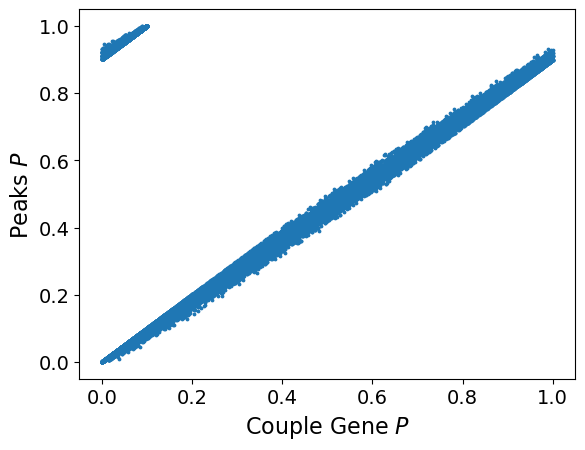

In [24]:
fig, ax = plt.subplots()

plt.scatter(couple_P_G, P_P, s=3)

plt.xticks(fontsize=14)  # Set x-tick label size
plt.yticks(fontsize=14)  # Set y-tick label size
plt.xlabel('Couple Gene $P$', fontsize=16)  # Set x-axis label with increased font size
plt.ylabel('Peaks $P$', fontsize=16)
fig.savefig('Benchmark/Simulation_gene_P_P_C_2.pdf', format='pdf', dpi=300)

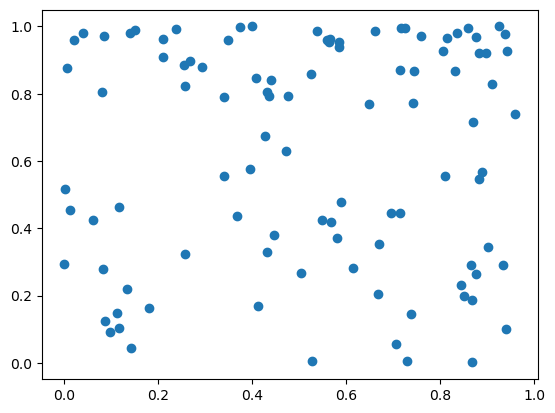

In [537]:
plt.scatter(P_P[0], decouple_P_G[0])